## Importazione librerie

In [99]:
import pandas as pd
import folium
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans

## Caricamento dati

In [118]:
# Caricamento dei dati dai file CSV
df_fastfood = pd.read_csv('datasets/fastfood.csv')
df_pollution = pd.read_csv('datasets/pollution.csv')
df_geo = pd.read_csv('datasets/US_GeoCode.csv')
df_heart = pd.read_csv('datasets/heart_2018.csv')

# Selezione di subset dei dati
df_subset_fastfood = df_fastfood[["num", "State", "latitude", "longitude", "name"]]
df_subset_pollution = df_pollution[["Year", "State", "O3 Mean", "CO Mean", "SO2 Mean", "NO2 Mean"]]
df_subset_GEO = df_geo[["latitude", "longitude", "State"]]
df_subset_heart = df_heart[["YEAR", "State", "RATE", "DEATHS"]]

# Dizionario per mappare le sigle delle province ai loro nomi completi
province_mapping = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California", "CO": "Colorado",
    "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine",
    "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico",
    "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon",
    "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington", "WV": "West Virginia",
    "WI": "Wisconsin", "WY": "Wyoming"
}

# Sostituisci le sigle delle province con i loro nomi completi
df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)
df_subset_pollution["State"] = df_subset_pollution["State"].map(province_mapping)
df_subset_pollution = df_pollution[['State', 'O3 Mean']]

# Aggregazione dei dati
fastfood_count = df_subset_fastfood.groupby('State').size().reset_index(name='fastfood_count')
pollution_mean = df_subset_pollution.groupby('State').mean().reset_index()

# Unione dei dati
data = df_subset_heart.merge(fastfood_count, on='State').merge(pollution_mean, on='State')

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1003/876043998.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1003/876043998.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)


## Analisi reti

### Rete dei fast food per stato
- Ogni nodo rappresenta un fast food e contiene le sue coordinate geografiche (latitudine e longitudine). Questi nodi sono contrassegnati dal tipo "fastfood".
- Ogni nodo rappresenta uno stato degli Stati Uniti. Questi nodi sono contrassegnati dal tipo "state".
- Gli archi connettono i fast food agli stati in cui sono situati. Ad esempio, se un fast food si trova in un certo stato, ci sarà un arco che collega il nodo del fast food al nodo dello stato corrispondente.

In [101]:
# Conta il numero di stati in cui è presente ciascuna catena di fast food
fastfood_state_counts = df_subset_fastfood.groupby('name')['State'].nunique()

# Ordina le catene di fast food in base al numero di stati in cui sono presenti
popular_fastfood = fastfood_state_counts.sort_values(ascending=False)

# Visualizza le catene di fast food più popolari
print(popular_fastfood)

name
Taco Bell                       49
McDonald's                      48
Burger King                     46
Wendy's                         45
Subway                          44
                                ..
Garden Catering                  1
Gangnam Style Korean Kitchen     1
Gambino's Pizza                  1
GD Bro Burger                    1
iSushi                           1
Name: State, Length: 571, dtype: int64


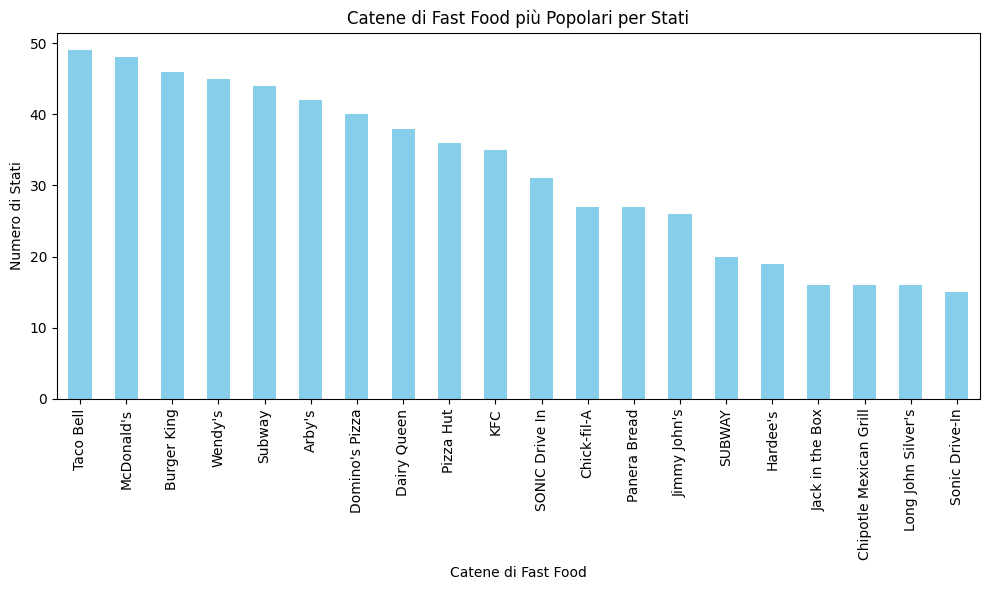

In [102]:
# Impostazioni per il grafico
plt.figure(figsize=(10, 6))

# Creazione del grafico a barre
(popular_fastfood.head(20)).plot(kind='bar', color='skyblue')

# Titoli e label
plt.title('Catene di Fast Food più Popolari per Stati')
plt.xlabel('Catene di Fast Food')
plt.ylabel('Numero di Stati')

# Mostra il grafico
plt.tight_layout()
plt.show()


#### Filtraggio

In [103]:
# Conteggio delle presenze di ciascuna catena di fast food negli stati
fastfood_presence = df_fastfood.groupby('name')['State'].nunique().sort_values(ascending=False)

# Seleziona solo le prime 20 catene di fast food più popolari
top_fastfood = fastfood_presence.head(20).index

# Filtra il DataFrame dei fast food tenendo solo le prime 20 catene più popolari
df_subset_fastfood_top = df_fastfood[df_fastfood['name'].isin(top_fastfood)]

In [104]:
# Creazione della rete dei fast food per stato
G_fastfood_top = nx.Graph()
for index, row in df_subset_fastfood_top.iterrows():
    G_fastfood_top.add_node(row['name'], type='fastfood', latitude=row['latitude'], longitude=row['longitude'])
    G_fastfood_top.add_node(row['State'], type='state')
    G_fastfood_top.add_edge(row['name'], row['State'])

In [105]:
# Stampa i dettagli dei nodi per verificare le coordinate
print("Dettagli dei nodi:")
for node, data in G_fastfood_top.nodes(data=True):
    print(node, data)

Dettagli dei nodi:
SONIC Drive In {'type': 'fastfood', 'latitude': 35.37719, 'longitude': -118.91516}
LA {'type': 'state'}
Taco Bell {'type': 'fastfood', 'latitude': 39.86891, 'longitude': -84.29297}
TN {'type': 'state'}
Arby's {'type': 'fastfood', 'latitude': 32.581842, 'longitude': -93.24889}
Wendy's {'type': 'fastfood', 'latitude': 39.8291, 'longitude': -84.0253}
MI {'type': 'state'}
Burger King {'type': 'fastfood', 'latitude': 32.32756, 'longitude': -111.04825}
Chipotle Mexican Grill {'type': 'fastfood', 'latitude': 39.59723846, 'longitude': -84.2314274}
CA {'type': 'state'}
Dairy Queen {'type': 'fastfood', 'latitude': 61.613815, 'longitude': -149.06532}
TX {'type': 'state'}
McDonald's {'type': 'fastfood', 'latitude': 34.18063, 'longitude': -119.16498}
NY {'type': 'state'}
MA {'type': 'state'}
MO {'type': 'state'}
GA {'type': 'state'}
OH {'type': 'state'}
Jack in the Box {'type': 'fastfood', 'latitude': 34.1551, 'longitude': -119.1952}
SC {'type': 'state'}
CT {'type': 'state'}
KY {

- La rete è visualizzata su una mappa interattiva degli Stati Uniti. 
- I fast food sono rappresentati da marcatori blu sulla mappa.

In [106]:
# Crea la mappa centrata sugli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Aggiungi la mappa degli Stati Uniti come base
folium.TileLayer('cartodbpositron').add_to(m)

# Aggiungi i marker per i fast food
for node, data in G_fastfood_top.nodes(data=True):
    # Assicurati che il nodo sia un fast food e che abbia le coordinate
    if data['type'] == 'fastfood':
        if 'latitude' in data and 'longitude' in data:
            # Ottieni le coordinate del fast food dal grafo
            coordinates = (data['latitude'], data['longitude'])
            # Aggiungi il marker sulla mappa
            folium.Marker(
                location=coordinates,
                popup=node,  # Mostra il nome del fast food quando si clicca sul marker
                icon=folium.Icon(color='blue')
            ).add_to(m)
        else:
            print(f"Nodo {node} di tipo fastfood non ha le coordinate.")

# Aggiungi i polilinea per gli archi
for edge in G_fastfood_top.edges():
    node1, node2 = edge
    data1 = G_fastfood_top.nodes[node1]
    data2 = G_fastfood_top.nodes[node2]
    # Verifica se gli attributi latitude e longitude sono presenti nei nodi
    if 'latitude' in data1 and 'longitude' in data1 and 'latitude' in data2 and 'longitude' in data2:
        # Ottieni le coordinate dei nodi collegati
        coordinates_source = (data1['latitude'], data1['longitude'])
        coordinates_target = (data2['latitude'], data2['longitude'])
        # Aggiungi la polilinea alla mappa
        folium.PolyLine([coordinates_source, coordinates_target], color='gray').add_to(m)

# Visualizza la mappa
m

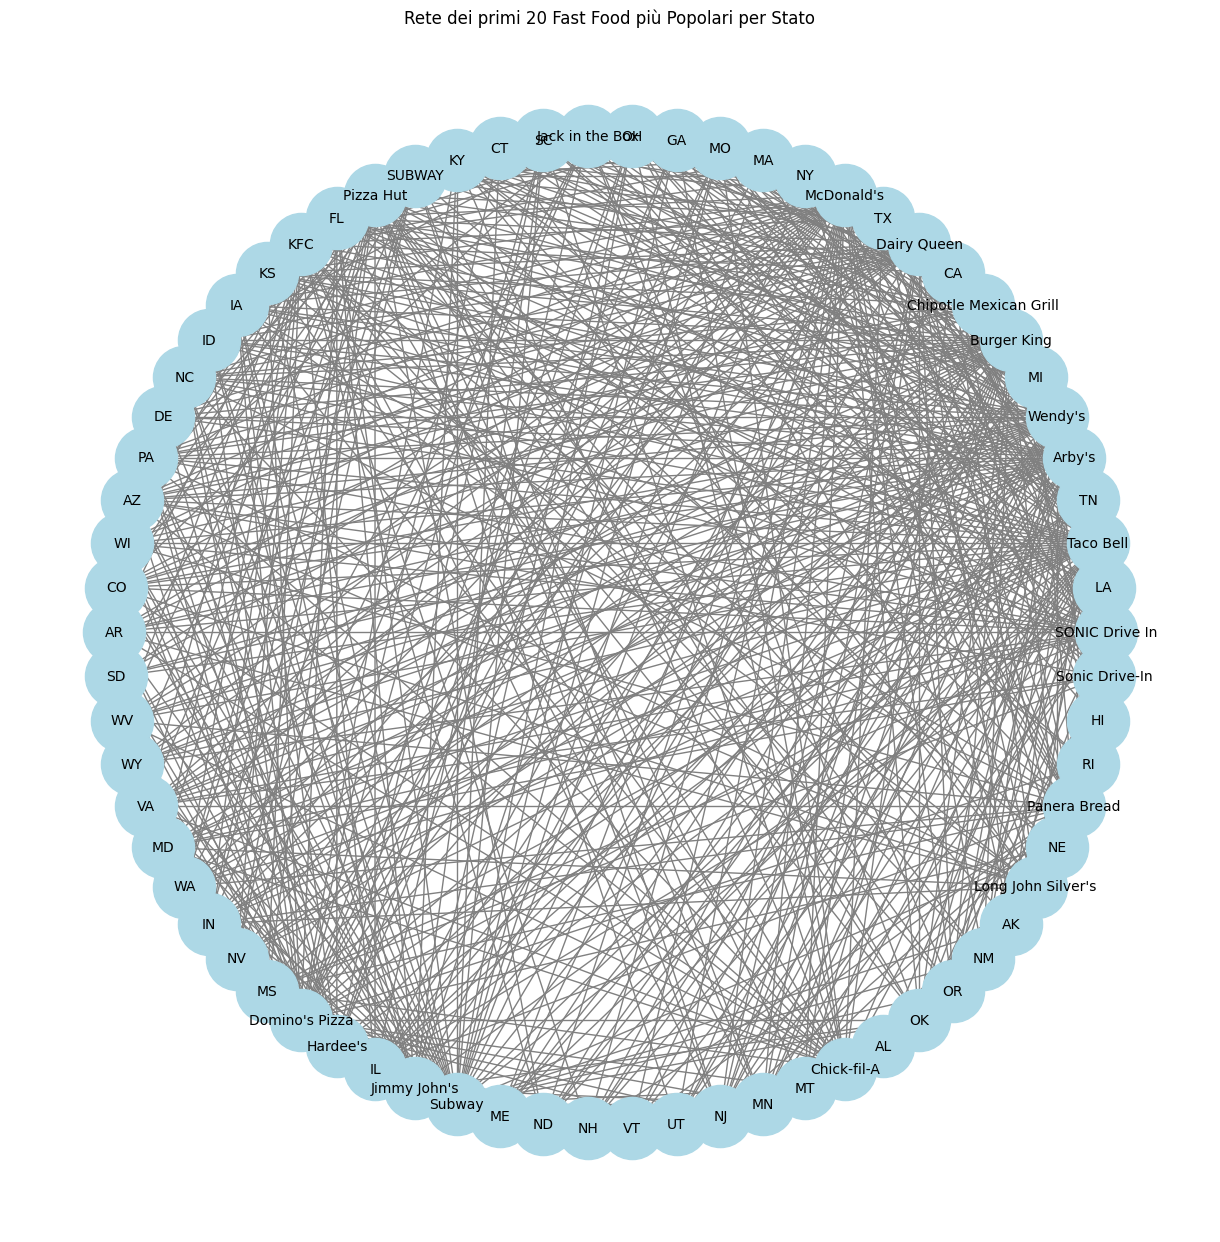

In [107]:
# Visualizzazione della rete con layout circolare
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G_fastfood_top)
nx.draw(G_fastfood_top, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete dei primi 20 Fast Food più Popolari per Stato')
plt.show()

In [108]:
# Debug: Verifica dei nodi e delle loro coordinate
for node in G_fastfood_top.nodes(data=True):
    print(node)

('SONIC Drive In', {'type': 'fastfood', 'latitude': 35.37719, 'longitude': -118.91516})
('LA', {'type': 'state'})
('Taco Bell', {'type': 'fastfood', 'latitude': 39.86891, 'longitude': -84.29297})
('TN', {'type': 'state'})
("Arby's", {'type': 'fastfood', 'latitude': 32.581842, 'longitude': -93.24889})
("Wendy's", {'type': 'fastfood', 'latitude': 39.8291, 'longitude': -84.0253})
('MI', {'type': 'state'})
('Burger King', {'type': 'fastfood', 'latitude': 32.32756, 'longitude': -111.04825})
('Chipotle Mexican Grill', {'type': 'fastfood', 'latitude': 39.59723846, 'longitude': -84.2314274})
('CA', {'type': 'state'})
('Dairy Queen', {'type': 'fastfood', 'latitude': 61.613815, 'longitude': -149.06532})
('TX', {'type': 'state'})
("McDonald's", {'type': 'fastfood', 'latitude': 34.18063, 'longitude': -119.16498})
('NY', {'type': 'state'})
('MA', {'type': 'state'})
('MO', {'type': 'state'})
('GA', {'type': 'state'})
('OH', {'type': 'state'})
('Jack in the Box', {'type': 'fastfood', 'latitude': 34.1

### Rete (semplice) dell'inquinamento per stato:

- I nodi rappresentano gli stati.
- Ogni nodo ha un attributo ozone_mean, che indica il livello medio di ozono in quel particolare stato.
- Gli archi sono stati aggiunti in base alla differenza dei valori medi dell'ozono tra due stati:
    se la differenza dei valori medi dell'ozono tra due stati è inferiore a una soglia predefinita, viene aggiunto un arco tra quei due stati.

In [109]:
# Calcola la media dell'ozono per stato
average_ozone_by_state = df_subset_pollution.groupby('State')['O3 Mean'].mean().reset_index()

# Crea il grafo
G_pollution = nx.Graph()

# Aggiungi i nodi per gli stati
for index, row in average_ozone_by_state.iterrows():
    G_pollution.add_node(row['State'], ozone_mean=row['O3 Mean'])

threshold = 5  # Esempio di soglia

# Aggiungi gli archi basati sulla differenza dei valori medi dell'ozono
for i in range(len(average_ozone_by_state)):
    for j in range(i+1, len(average_ozone_by_state)):
        state1 = average_ozone_by_state.iloc[i]['State']
        state2 = average_ozone_by_state.iloc[j]['State']
        ozone1 = average_ozone_by_state.iloc[i]['O3 Mean']
        ozone2 = average_ozone_by_state.iloc[j]['O3 Mean']
        if abs(ozone1 - ozone2) < threshold:
            G_pollution.add_edge(state1, state2)


La rete è visualizzata utilizzando un layout a molla per distribuire i nodi in modo ottimale sulla visualizzazione.
La dimensione dei nodi è proporzionale alla loro centralità, mentre il colore dei nodi indica il livello medio di ozono in ciascuno stato (più chiara è la tonalità di verde, più basso è il livello di ozono).

In [110]:
# Visualizza la rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_pollution)
nx.draw(G_pollution, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10)
plt.title('Rete dell\'inquinamento per stato (O3 Mean)')
plt.show()


### Rete (semplice) degli attacchi di cuore per stato:

- Ogni nodo nella rete rappresenta uno stato degli Stati Uniti. 
- I nodi sono stati ottenuti dai dati relativi agli attacchi di cuore, con l'attributo aggiuntivo type impostato su "state" per identificare il tipo di nodo.
- Gli archi sono stati aggiunti in base alla similitudine dei tassi di attacchi di cuore tra 2 stati. Hai impostato una soglia di similitudine, con una differenza massima di 10 tra i tassi di attacchi di cuore per considerare due stati simili. Se la differenza tra i tassi di attacchi di cuore di due stati è inferiore alla soglia definita, viene aggiunto un arco tra quei due stati.

In [111]:
# Creazione della rete degli attacchi di cuore per stato
G_heart = nx.Graph()
for index, row in df_subset_heart.iterrows():
    G_heart.add_node(row['State'], type='state')


# Definisci una soglia per la similitudine
threshold = 10  # Differenza massima tra i tassi di attacchi di cuore per considerare due stati simili

# Aggiungi gli archi basati sulla similitudine dei tassi di attacchi di cuore
for i in range(len(df_subset_heart)):
    for j in range(i+1, len(df_subset_heart)):
        state1 = df_subset_heart.iloc[i]['State']
        state2 = df_subset_heart.iloc[j]['State']
        rate1 = df_subset_heart.iloc[i]['RATE']
        rate2 = df_subset_heart.iloc[j]['RATE']
        if abs(rate1 - rate2) < threshold:
            G_heart.add_edge(state1, state2)


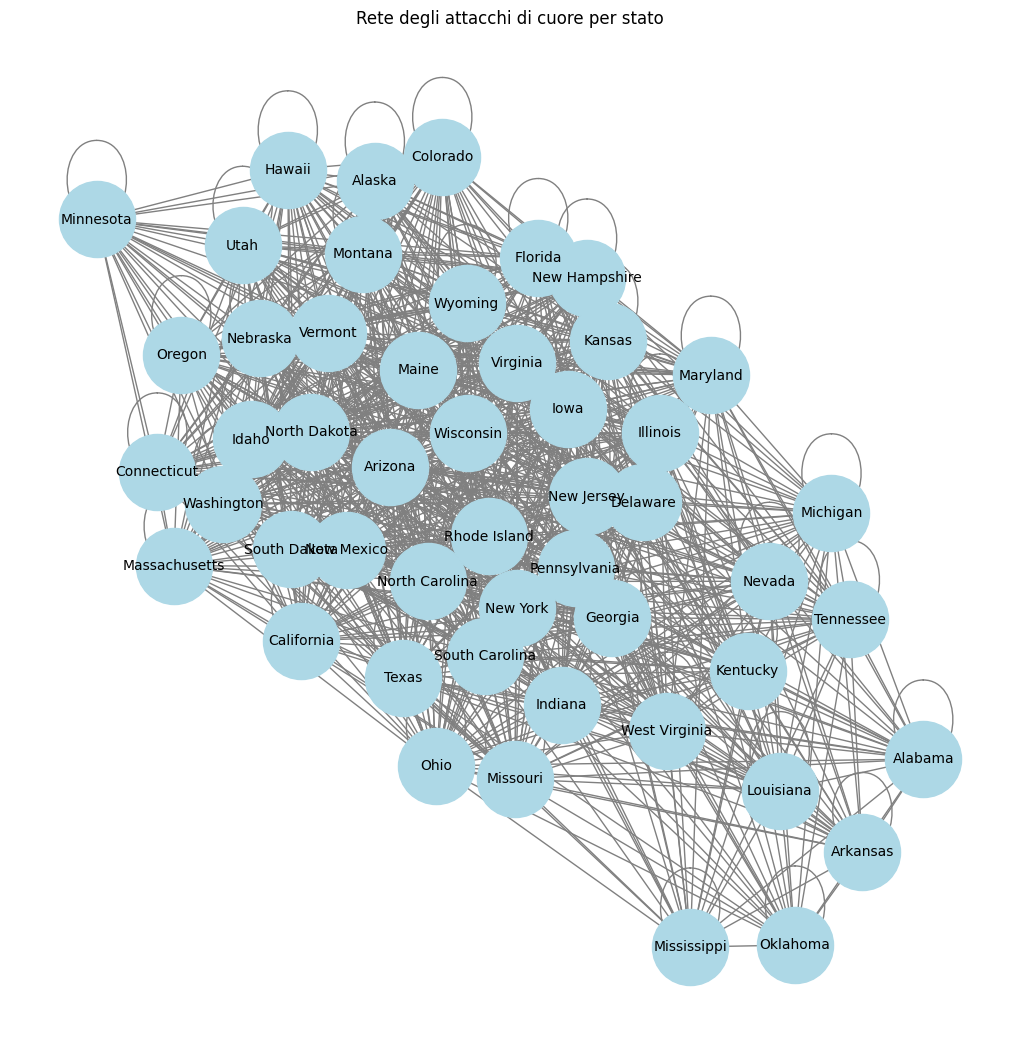

In [112]:
# Visualizzazione della rete
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_heart)  # Posizionamento dei nodi
nx.draw(G_heart, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete degli attacchi di cuore per stato')
plt.show()

### Rete di correlazione (semplice) tra attacchi di cuore e fast food
- Ogni nodo nella rete rappresenta uno stato degli Stati Uniti. 
- I nodi sono stati ottenuti dai dati combinati relativi agli attacchi di cuore e alla presenza di fast food, con l'attributo aggiuntivo type impostato su "state" per identificare il tipo di nodo. 
- Ogni nodo include anche informazioni sul tasso di attacchi di cuore (rate) e sul conteggio dei fast food presenti (fastfood_count).
- Gli archi sono stati aggiunti in base alla similitudine dei tassi di attacchi di cuore e del numero di fast food tra 2 stati. Abbiamo definito due soglie di similitudine: 
1. una per la differenza massima nei tassi di attacchi di cuore (threshold_rate) 
2. una per la differenza massima nel numero di fast food (threshold_fastfood). 

Se la differenza tra i tassi di attacchi di cuore e il numero di fast food di due stati è inferiore alle soglie definite, viene aggiunto un arco tra quei due stati.

In [119]:
# Creazione della rete di correlazione tra attacchi di cuore e fast food
G_heart_fastfood = nx.Graph()
for index, row in data.iterrows():
    G_heart_fastfood.add_node(row['State'], type='state', rate=row['RATE'], fastfood_count=row['fastfood_count'])

# Definisci una soglia per la similitudine
threshold_rate = 10  # Differenza massima tra i tassi di attacchi di cuore per considerare due stati simili
threshold_fastfood = 20  # Differenza massima tra il numero di fast food per considerare due stati simili

# Aggiungi gli archi basati sulla similitudine dei tassi di attacchi di cuore e del numero di fast food
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        state1 = data.iloc[i]['State']
        state2 = data.iloc[j]['State']
        rate1 = data.iloc[i]['RATE']
        rate2 = data.iloc[j]['RATE']
        fastfood_count1 = data.iloc[i]['fastfood_count']
        fastfood_count2 = data.iloc[j]['fastfood_count']
        if abs(rate1 - rate2) < threshold_rate and abs(fastfood_count1 - fastfood_count2) < threshold_fastfood:
            G_heart_fastfood.add_edge(state1, state2)


In [120]:
# Visualizzazione della rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_heart_fastfood)  # Posizionamento dei nodi
nx.draw(G_heart_fastfood, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete di correlazione tra attacchi di cuore e fast food')
plt.show()

### Rete di correlazione (semplice) tra attacchi di cuore e inquinamento
- I nodi nella rete rappresentano gli stati degli Stati Uniti. 
- Ogni nodo contiene informazioni sull'attributo type, impostato su "state" per identificare il tipo di nodo, il tasso di attacchi di cuore (rate) e il livello medio di ozono (o3_mean).
- Gli archi sono stati aggiunti in base alla similitudine nei tassi di attacchi di cuore e nei livelli di inquinamento atmosferico (ozono) tra due stati. Abbiamo definito due soglie di similitudine: 
1. una per la differenza massima nei tassi di attacchi di cuore (threshold_rate) 
2. una per la differenza massima nei livelli di ozono (threshold_ozone). 

Se la differenza tra i tassi di attacchi di cuore e i livelli di ozono di due stati è inferiore alle soglie definite, viene aggiunto un arco tra quei due stati.


In [121]:
# Creazione della rete di correlazione tra attacchi di cuore e inquinamento
G_heart_pollution = nx.Graph()
for index, row in data.iterrows():
    G_heart_pollution.add_node(row['State'], type='state', rate=row['RATE'], o3_mean=row['O3 Mean'])

# Definisci una soglia per la similitudine
threshold_rate = 10  # Differenza massima tra i tassi di attacchi di cuore per considerare due stati simili
threshold_ozone = 5  # Differenza massima tra i livelli di O3 per considerare due stati simili

# Aggiungi gli archi basati sulla similitudine dei tassi di attacchi di cuore e dei livelli di inquinamento
for i in range(len(data)):
    for j in range(i+1, len(data)):
        state1 = data.iloc[i]['State']
        state2 = data.iloc[j]['State']
        rate1 = data.iloc[i]['RATE']
        rate2 = data.iloc[j]['RATE']
        ozone1 = data.iloc[i]['O3 Mean']
        ozone2 = data.iloc[j]['O3 Mean']
        if abs(rate1 - rate2) < threshold_rate and abs(ozone1 - ozone2) < threshold_ozone:
            G_heart_pollution.add_edge(state1, state2)


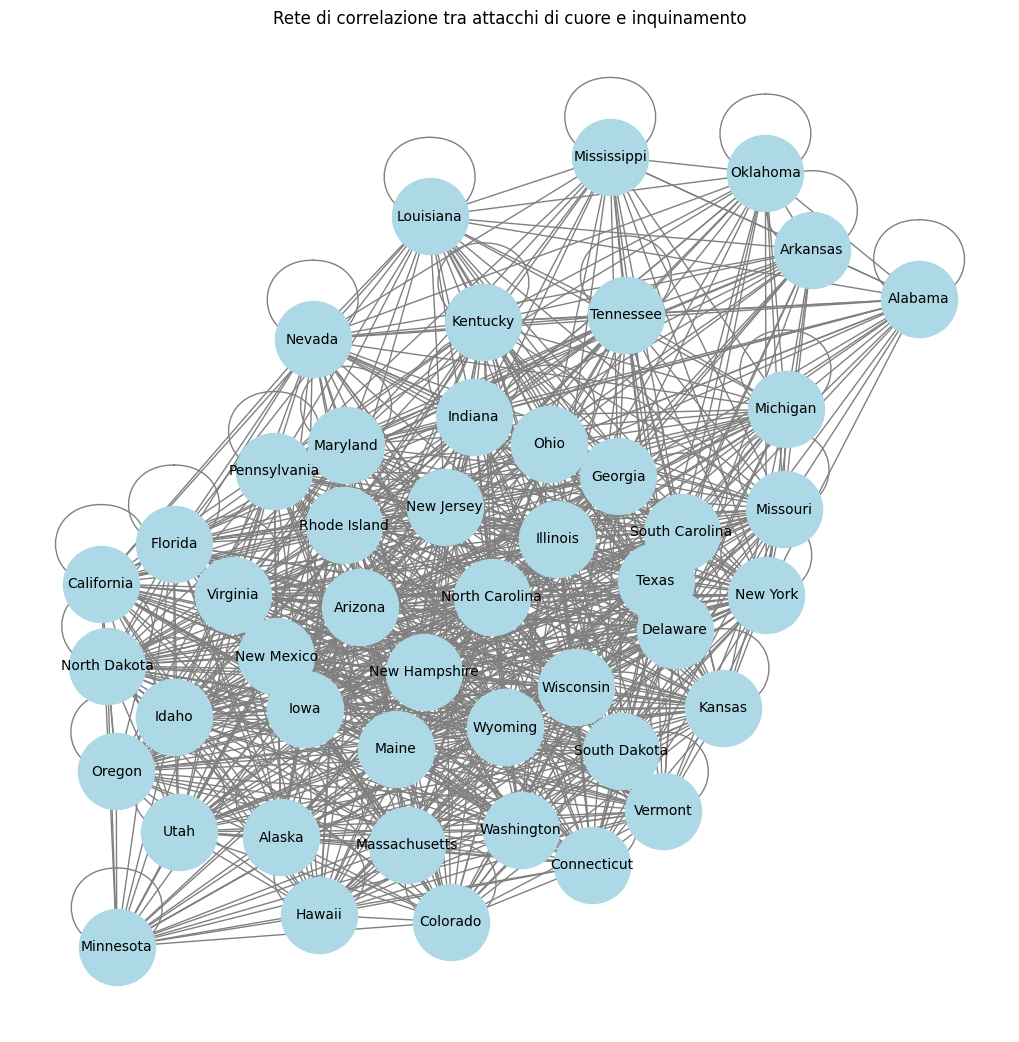

In [122]:
# Visualizzazione della rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_heart_pollution)  # Posizionamento dei nodi
nx.draw(G_heart_pollution, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete di correlazione tra attacchi di cuore e inquinamento')
plt.show()

### Rete di correlazione tra fast food, inquinamento e attacchi di cuore:

- Potresti creare una rete che collega i fast food, i livelli di inquinamento e gli attacchi di cuore.
- Potresti utilizzare le informazioni geografiche dal DataFrame df_geo per associare i dati alle posizioni geografiche corrispondenti.

In [123]:
# Creazione di una rete che collega i fast food, i livelli di inquinamento e gli attacchi di cuore
G_combined = nx.Graph()

# Aggiunta dei nodi per i fast food
for index, row in df_subset_fastfood.iterrows():
    G_combined.add_node(row['name'], type='fast_food', latitude=row['latitude'], longitude=row['longitude'])

# Aggiunta dei nodi per gli stati
for index, row in df_subset_GEO.iterrows():
    G_combined.add_node(row['State'], type='state', latitude=row['latitude'], longitude=row['longitude'])

# Aggiunta dei nodi per i dati di inquinamento
for index, row in df_subset_pollution.iterrows():
    G_combined.add_node(row['State'], type='pollution')

# Aggiunta dei nodi per i dati sugli attacchi di cuore
for index, row in df_subset_heart.iterrows():
    G_combined.add_node(row['State'], type='heart_attack')

# Aggiunta degli archi per collegare i nodi
# Puoi definire tu come creare questi collegamenti in base alle relazioni tra i diversi tipi di dati

# Ad esempio, potresti collegare i fast food agli stati in base alla loro presenza, e gli stati ai dati di inquinamento e attacchi di cuore.
# Oppure potresti aggiungere archi che rappresentano relazioni di similitudine o correlazione tra i diversi nodi.

# Aggiungi archi tra i fast food e gli stati
for index, row in df_subset_fastfood.iterrows():
    G_combined.add_edge(row['name'], row['State'])

# Aggiungi archi tra gli stati e i dati di inquinamento
for index, row in df_subset_pollution.iterrows():
    G_combined.add_edge(row['State'], row['State'], type='pollution_data')

# Aggiungi archi tra gli stati e i dati sugli attacchi di cuore
for index, row in df_subset_heart.iterrows():
    G_combined.add_edge(row['State'], row['State'], type='heart_attack_data')

In [124]:
# Visualizzazione della rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_combined)  # Posizionamento dei nodi
nx.draw(G_combined, pos, with_labels=True, node_size=3000, font_size=10)
plt.title('Rete di correlazione tra fast food, inquinamento e attacchi di cuore')
plt.show()

# Misure di analisi delle reti

### Applicazione delle misure di analisi delle reti alla rete dei fast food per stato

Centralità di Grado: {'SONIC Drive In': 0.4492753623188406, 'LA': 0.2318840579710145, 'Taco Bell': 0.7101449275362319, 'TN': 0.2463768115942029, "Arby's": 0.6086956521739131, "Wendy's": 0.6521739130434783, 'MI': 0.21739130434782608, 'Burger King': 0.6666666666666666, 'Chipotle Mexican Grill': 0.2318840579710145, 'CA': 0.2753623188405797, 'Dairy Queen': 0.5507246376811594, 'TX': 0.2753623188405797, "McDonald's": 0.6956521739130435, 'NY': 0.2028985507246377, 'MA': 0.15942028985507248, 'MO': 0.2318840579710145, 'GA': 0.21739130434782608, 'OH': 0.2753623188405797, 'Jack in the Box': 0.2318840579710145, 'SC': 0.21739130434782608, 'CT': 0.11594202898550725, 'KY': 0.2463768115942029, 'SUBWAY': 0.2898550724637681, 'Pizza Hut': 0.5217391304347826, 'FL': 0.2608695652173913, 'KFC': 0.5072463768115942, 'KS': 0.18840579710144928, 'IA': 0.21739130434782608, 'ID': 0.17391304347826086, 'NC': 0.2318840579710145, 'DE': 0.11594202898550725, 'PA': 0.2463768115942029, 'AZ': 0.2608695652173913, 'WI': 0.1884

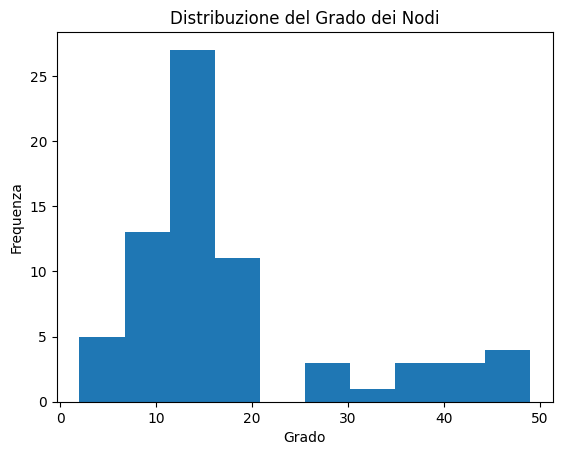

In [139]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G_fastfood_top)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_fastfood_top)

# Clustering Coefficient
clustering_coefficient = nx.clustering(G_fastfood_top)

# Analisi della Modularità
try:
    modularity = nx.community.modularity(G_fastfood_top, nx.community.greedy_modularity_communities(G_fastfood_top))
except NotImplementedError:
    modularity = "Modularità non supportata per questa rete"

# Small-Worldness
average_clustering = nx.average_clustering(G_fastfood_top)
average_shortest_path_length = nx.average_shortest_path_length(G_fastfood_top)
small_worldness = average_clustering / average_shortest_path_length

# Converti il grafo non diretto in un grafo diretto
G_directed = nx.DiGraph(G_fastfood_top)

# Censimento delle Triadi
triad_census = nx.triadic_census(G_directed)

# Nucleo-Periferia
core_number = nx.core_number(G_fastfood_top)

print("Centralità di Grado:", degree_centrality)
print("Centralità di Betweenness:", betweenness_centrality)
print("Coefficiente di Clustering:", clustering_coefficient)
print("Modularità:", modularity)
print("Small-Worldness:", small_worldness)
print("Censimento delle Triadi:", triad_census)
print("Nucleo-Periferia:", core_number)

# Plot della distribuzione del grado
degree_distribution = [d for n, d in G_fastfood_top.degree()]
plt.hist(degree_distribution)
plt.title('Distribuzione del Grado dei Nodi')
plt.xlabel('Grado')
plt.ylabel('Frequenza')
plt.show()


### Applicazione delle misure di analisi delle reti alla rete dell'inquinamento per stato

In [144]:
# Degree Centrality
degree_centrality_pollution = nx.degree_centrality(G_pollution)

# Betweenness Centrality
betweenness_centrality_pollution = nx.betweenness_centrality(G_pollution)

# Clustering Coefficient
clustering_coefficient_pollution = nx.clustering(G_pollution)

# Connected Components (Strongly connected components for directed graph)
if nx.is_directed(G_pollution):
    connected_components = nx.strongly_connected_components(G_pollution)
else:
    connected_components = nx.connected_components(G_pollution)

# Largest Connected Component
largest_connected_component = max(connected_components, key=len)

# Modularity (using greedy modularity communities for example)
communities = nx.community.greedy_modularity_communities(G_pollution)
try:
    modularity = nx.community.modularity(G_pollution, communities)
except NotImplementedError:
    modularity = "Modularità non supportata per questa rete"

print("Centralità di Grado:", degree_centrality_pollution)
print("Centralità di Betweenness:", betweenness_centrality_pollution)
print("Coefficiente di Clustering:", clustering_coefficient_pollution)
print("Largest Connected Component Size:", len(largest_connected_component))
print("Modularità:", modularity)

# Similarità Multiplex
# Nota: la similarità multiplex dipende dai dati multiplex, quindi necessiti di più informazioni per calcolarla

# Small-Worldness
average_clustering_pollution = nx.average_clustering(G_pollution)
average_shortest_path_length_pollution = nx.average_shortest_path_length(G_pollution)
small_worldness_pollution = average_clustering_pollution / average_shortest_path_length_pollution

print("Small-Worldness:", small_worldness_pollution)

# Converti il grafo non diretto in un grafo diretto
G_directed_pollution = nx.DiGraph(G_pollution) 

# Censimento delle Triadi
triad_census_pollution = nx.triadic_census(G_directed_pollution)

print("Censimento delle Triadi:", triad_census_pollution)

# Nucleo-Periferia
core_number_pollution = nx.core_number(G_pollution)

print("Nucleo-Periferia:", core_number_pollution)

# Plot Degree Distribution
degree_distribution_pollution = [d for n, d in G_pollution.degree()]
plt.hist(degree_distribution_pollution, bins=10)
plt.title('Distribuzione del Grado dei Nodi')
plt.xlabel('Grado')
plt.ylabel('Frequenza')
plt.show()

Centralità di Grado: {'Alabama': 1.0, 'Alaska': 1.0, 'Arizona': 1.0, 'Arkansas': 1.0, 'California': 1.0, 'Colorado': 1.0, 'Connecticut': 1.0, 'Delaware': 1.0, 'District Of Columbia': 1.0, 'Florida': 1.0, 'Georgia': 1.0, 'Hawaii': 1.0, 'Idaho': 1.0, 'Illinois': 1.0, 'Indiana': 1.0, 'Iowa': 1.0, 'Kansas': 1.0, 'Kentucky': 1.0, 'Louisiana': 1.0, 'Maine': 1.0, 'Maryland': 1.0, 'Massachusetts': 1.0, 'Michigan': 1.0, 'Minnesota': 1.0, 'Mississippi': 1.0, 'Missouri': 1.0, 'Nevada': 1.0, 'New Hampshire': 1.0, 'New Jersey': 1.0, 'New Mexico': 1.0, 'New York': 1.0, 'North Carolina': 1.0, 'North Dakota': 1.0, 'Ohio': 1.0, 'Oklahoma': 1.0, 'Oregon': 1.0, 'Pennsylvania': 1.0, 'Rhode Island': 1.0, 'South Carolina': 1.0, 'South Dakota': 1.0, 'Tennessee': 1.0, 'Texas': 1.0, 'Utah': 1.0, 'Vermont': 1.0, 'Virginia': 1.0, 'Washington': 1.0, 'Wisconsin': 1.0, 'Wyoming': 1.0}
Centralità di Betweenness: {'Alabama': 0.0, 'Alaska': 0.0, 'Arizona': 0.0, 'Arkansas': 0.0, 'California': 0.0, 'Colorado': 0.0, 'Con

### Applicazione delle misure di analisi delle reti alla rete degli attacchi di cuore per stato

In [147]:
# Degree Centrality
degree_centrality_heart = nx.degree_centrality(G_heart)

# Betweenness Centrality
betweenness_centrality_heart = nx.betweenness_centrality(G_heart)

# Clustering Coefficient
clustering_coefficient_heart = nx.clustering(G_heart)

# Analisi della Modularità
try:
    modularity_heart = nx.community.modularity(G_heart, nx.community.greedy_modularity_communities(G_heart))
except NotImplementedError:
    modularity_heart = "Modularità non supportata per questa rete"

# Similarità Multiplex
# Nota: la similarità multiplex dipende dai dati multiplex, quindi necessiti di più informazioni per calcolarla

# Small-Worldness
average_clustering_heart = nx.average_clustering(G_heart)
average_shortest_path_length_heart = nx.average_shortest_path_length(G_heart)
small_worldness_heart = average_clustering_heart / average_shortest_path_length_heart

# Converti il grafo non diretto in un grafo diretto
G_directed_heart = nx.DiGraph(G_heart)

# Converti il grafo non diretto in un grafo diretto
G_directed_heart = nx.DiGraph(G_heart)

# Censimento delle Triadi
triad_census_heart = nx.triadic_census(G_directed_heart)
# Rimuovi i cicli di auto-looping dal grafo
G_heart.remove_edges_from(nx.selfloop_edges(G_heart))

# Nucleo-Periferia
core_number_heart = nx.core_number(G_heart)

print("Centralità di Grado:", degree_centrality_heart)
print("Centralità di Betweenness:", betweenness_centrality_heart)
print("Coefficiente di Clustering:", clustering_coefficient_heart)
print("Analisi della Modularità:", modularity_heart)
print("Small-Worldness:", small_worldness_heart)
print("Censimento delle Triadi:", triad_census_heart)
print("Nucleo-Periferia:", core_number_heart)


Centralità di Grado: {'Alabama': 0.5102040816326531, 'Alaska': 0.7755102040816326, 'Arizona': 0.9387755102040816, 'Arkansas': 0.5102040816326531, 'California': 0.8163265306122448, 'Colorado': 0.7551020408163265, 'Connecticut': 0.8163265306122448, 'Delaware': 0.9795918367346939, 'Florida': 0.8571428571428571, 'Georgia': 0.9795918367346939, 'Hawaii': 0.7346938775510203, 'Idaho': 0.8775510204081632, 'Illinois': 0.8979591836734693, 'Indiana': 0.8979591836734693, 'Iowa': 0.9183673469387754, 'Kansas': 0.9183673469387754, 'Kentucky': 0.7142857142857142, 'Louisiana': 0.5714285714285714, 'Maine': 0.9183673469387754, 'Maryland': 0.8979591836734693, 'Massachusetts': 0.7755102040816326, 'Michigan': 0.673469387755102, 'Minnesota': 0.5714285714285714, 'Mississippi': 0.4897959183673469, 'Missouri': 0.836734693877551, 'Montana': 0.8163265306122448, 'Nebraska': 0.836734693877551, 'Nevada': 0.673469387755102, 'New Hampshire': 0.9387755102040816, 'New Jersey': 0.9387755102040816, 'New Mexico': 0.91836734

### Applicazione delle misure di analisi delle reti alla rete di correlazione tra attacchi di cuore e fast food o inquinamento

Attacchi di cuore e fastfood

In [154]:
# Rimuovi i cicli di auto-looping dal grafo
G_heart_fastfood_no_selfloops = G_heart_fastfood.copy()
G_heart_fastfood_no_selfloops.remove_edges_from(nx.selfloop_edges(G_heart_fastfood))

# Seleziona la componente connessa più grande
largest_component = max(nx.connected_components(G_heart_fastfood_no_selfloops), key=len)

# Costruisci un sottografo solo con la componente connessa più grande
G_largest_component = G_heart_fastfood_no_selfloops.subgraph(largest_component)

# Calcola la lunghezza media del percorso più breve solo sulla componente connessa più grande
average_shortest_path_length_heart_fastfood = nx.average_shortest_path_length(G_largest_component)

# Calcola le altre misure solo sulla componente connessa più grande
degree_centrality_heart_fastfood = nx.degree_centrality(G_largest_component)
betweenness_centrality_heart_fastfood = nx.betweenness_centrality(G_largest_component)
clustering_coefficient_heart_fastfood = nx.clustering(G_largest_component)

# Analisi della Modularità
try:
    modularity_heart_fastfood = nx.community.modularity(G_largest_component, nx.community.greedy_modularity_communities(G_largest_component))
except NotImplementedError:
    modularity_heart_fastfood = "Modularità non supportata per questa rete"

# Similarità Multiplex (se applicabile)
# Nota: la similarità multiplex dipende dai dati multiplex, quindi necessiti di più informazioni per calcolarla

# Small-Worldness
average_clustering_heart_fastfood = nx.average_clustering(G_largest_component)
average_shortest_path_length_heart_fastfood = nx.average_shortest_path_length(G_largest_component)
small_worldness_heart_fastfood = average_clustering_heart_fastfood / average_shortest_path_length_heart_fastfood

# Converti il grafo non diretto in un grafo diretto
G_directed_heart_fastfood = nx.DiGraph(G_largest_component)

# Censimento delle Triadi
triad_census_heart_fastfood = nx.triadic_census(G_directed_heart_fastfood)

# Nucleo-Periferia (assicurati di rimuovere i cicli di auto-looping se presenti)
try:
    core_number_heart_fastfood = nx.core_number(G_largest_component)
except nx.NetworkXError:
    core_number_heart_fastfood = "Impossibile calcolare il nucleo-periferia a causa di cicli di auto-looping nel grafo"

print("Centralità di Grado:", degree_centrality_heart_fastfood)
print("Centralità di Betweenness:", betweenness_centrality_heart_fastfood)
print("Coefficiente di Clustering:", clustering_coefficient_heart_fastfood)
print("Analisi della Modularità:", modularity_heart_fastfood)
print("Small-Worldness:", small_worldness_heart_fastfood)
print("Censimento delle Triadi:", triad_census_heart_fastfood)
print("Nucleo-Periferia:", core_number_heart_fastfood)


Centralità di Grado: {'North Dakota': 0.5625, 'Utah': 0.3125, 'Hawaii': 0.625, 'Delaware': 0.625, 'New Hampshire': 0.6875, 'Idaho': 0.4375, 'South Dakota': 0.5, 'Alabama': 0.0625, 'New Mexico': 0.125, 'Kansas': 0.125, 'Alaska': 0.4375, 'Maine': 0.5625, 'Connecticut': 0.375, 'Vermont': 0.375, 'Mississippi': 0.0625, 'Rhode Island': 0.4375, 'Wyoming': 0.5625}
Centralità di Betweenness: {'North Dakota': 0.02861111111111111, 'Utah': 0.23333333333333334, 'Hawaii': 0.07378968253968253, 'Delaware': 0.27702380952380956, 'New Hampshire': 0.12200396825396823, 'Idaho': 0.06809523809523808, 'South Dakota': 0.009166666666666667, 'Alabama': 0.0, 'New Mexico': 0.0, 'Kansas': 0.0, 'Alaska': 0.005, 'Maine': 0.041964285714285704, 'Connecticut': 0.04071428571428571, 'Vermont': 0.0, 'Mississippi': 0.0, 'Rhode Island': 0.125, 'Wyoming': 0.041964285714285704}
Coefficiente di Clustering: {'North Dakota': 0.75, 'Utah': 0.4, 'Hawaii': 0.7111111111111111, 'Delaware': 0.5555555555555556, 'New Hampshire': 0.654545

Multi-Grafo

Coefficiente di Correlazione:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Modularità: Modularità non supportata per i multigrafi
Similarità Multiplex: Similarità Multiplex non supportata per i multigrafi
Centralità di Betweenness Multigrafo: {}


# VEDIAMO ORA RETI PIU' COMPLESSE

## GRAFO BIPARTITO
Questo grafo prende in considerazione gli stati e tre variabili: il tasso di attacchi di cuore, la media dell'inquinamento (usando l'O3 come esempio) e la densità dei fast food. Queste variabili sono considerate come un insieme separato di nodi rispetto agli stati. Gli archi sono aggiunti tra gli stati e ciascuna variabile con un peso corrispondente ai valori dei dati.


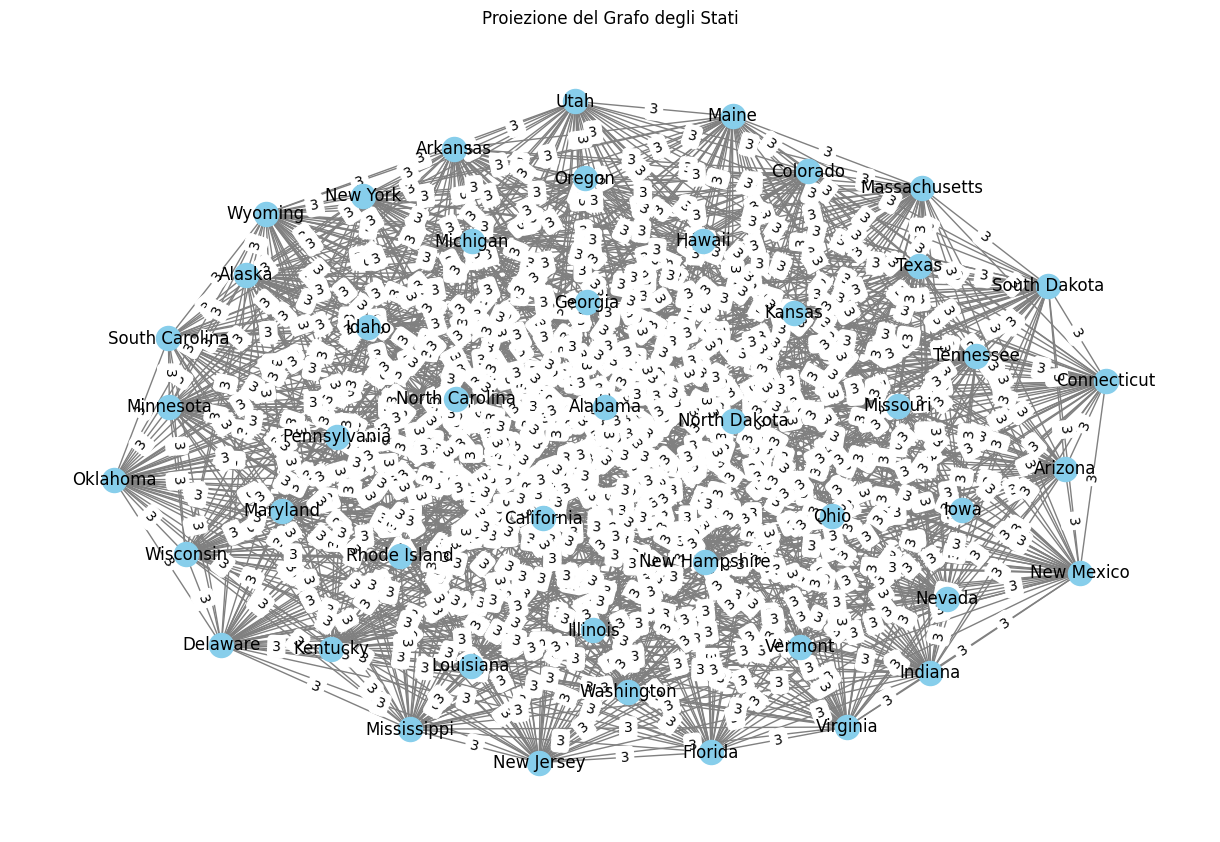

Centralità di Grado: {'Alabama': 1.0, 'Alaska': 1.0, 'Arizona': 1.0, 'Arkansas': 1.0, 'California': 1.0, 'Colorado': 1.0, 'Connecticut': 1.0, 'Delaware': 1.0, 'Florida': 1.0, 'Georgia': 1.0, 'Hawaii': 1.0, 'Idaho': 1.0, 'Illinois': 1.0, 'Indiana': 1.0, 'Iowa': 1.0, 'Kansas': 1.0, 'Kentucky': 1.0, 'Louisiana': 1.0, 'Maine': 1.0, 'Maryland': 1.0, 'Massachusetts': 1.0, 'Michigan': 1.0, 'Minnesota': 1.0, 'Mississippi': 1.0, 'Missouri': 1.0, 'Nevada': 1.0, 'New Hampshire': 1.0, 'New Jersey': 1.0, 'New Mexico': 1.0, 'New York': 1.0, 'North Carolina': 1.0, 'North Dakota': 1.0, 'Ohio': 1.0, 'Oklahoma': 1.0, 'Oregon': 1.0, 'Pennsylvania': 1.0, 'Rhode Island': 1.0, 'South Carolina': 1.0, 'South Dakota': 1.0, 'Tennessee': 1.0, 'Texas': 1.0, 'Utah': 1.0, 'Vermont': 1.0, 'Virginia': 1.0, 'Washington': 1.0, 'Wisconsin': 1.0, 'Wyoming': 1.0}
Centralità di Betweenness: {'Alabama': 0.0, 'Alaska': 0.0, 'Arizona': 0.0, 'Arkansas': 0.0, 'California': 0.0, 'Colorado': 0.0, 'Connecticut': 0.0, 'Delaware': 0

In [163]:
# Creazione del grafo bipartito
B = nx.Graph()

# Aggiunta dei nodi: Stati e variabili
states = data['State'].unique()
variables = ['Heart Attack Rate', 'Pollution Mean', 'Fast Food Density']

B.add_nodes_from(states, bipartite=0)
B.add_nodes_from(variables, bipartite=1)

# Aggiunta degli archi con pesi
for _, row in data.iterrows():
    B.add_edge(row['State'], 'Heart Attack Rate', weight=row['RATE'])
    B.add_edge(row['State'], 'Pollution Mean', weight=row['O3 Mean'])  # Usa la media dell'O3 come esempio
    B.add_edge(row['State'], 'Fast Food Density', weight=row['fastfood_count'])

# Estrazione delle proiezioni bipartite
G_states = nx.bipartite.weighted_projected_graph(B, states)
G_variables = nx.bipartite.weighted_projected_graph(B, variables)

# Visualizzazione della proiezione degli stati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_states)
nx.draw(G_states, pos, with_labels=True, node_color="skyblue", edge_color="gray")
labels = nx.get_edge_attributes(G_states, 'weight')
nx.draw_networkx_edge_labels(G_states, pos, edge_labels=labels)
plt.title("Proiezione del Grafo degli Stati")
plt.show()

# Analisi della rete
degree_centrality = nx.degree_centrality(G_states)
betweenness_centrality = nx.betweenness_centrality(G_states)
clustering_coefficient = nx.clustering(G_states)

# Analisi della modularità (proiezione degli stati)
try:
    communities = list(nx.community.greedy_modularity_communities(G_states))
    modularity = nx.community.modularity(G_states, communities)
except Exception as e:
    modularity = str(e)

# Small-Worldness
average_clustering = nx.average_clustering(G_states)
average_shortest_path_length = nx.average_shortest_path_length(G_states)
small_worldness = average_clustering / average_shortest_path_length

# Risultati
print("Centralità di Grado:", degree_centrality)
print("Centralità di Betweenness:", betweenness_centrality)
print("Coefficiente di Clustering:", clustering_coefficient)
print("Modularità:", modularity)
print("Small-Worldness:", small_worldness)

## Analisi risultati

1. Centralità di Grado: tutti gli stati hanno una centralità di grado pari a 1.0. Questo indica che ciascuno stato è direttamente connesso a tutte e tre le variabili ('Heart Attack Rate', 'Pollution Mean', 'Fast Food Density'). Nel grafo bipartito, questo suggerisce che ogni stato ha collegamenti con tutte le variabili, ma nella proiezione, ogni stato ha solo un collegamento con gli altri nodi proiettati se condividono variabili.

2. Centralità di Betweenness: è 0 per tutti gli stati, significa che nessuno stato funge da intermediario per la connessione tra altri stati. In altre parole, non ci sono percorsi che passano attraverso uno stato per connettere altri stati, il che è previsto data la natura della proiezione del grafo bipartito con i dati attuali.

3. Coefficiente di Clustering: tutti gli stati hanno un coefficiente di clustering pari a 1.0. Questo indica che il sottografo formato dai vicini di ciascuno stato è completamente connesso. Tuttavia, dato che ogni stato è connesso direttamente a tutte le variabili e non ci sono connessioni dirette tra gli stati, il coefficiente di clustering risulta essere 1.0.

4. Modularità: è 0.0, il che significa che il grafo non ha una struttura comunitaria significativa. In altre parole, non ci sono gruppi di stati che sono più densamente connessi tra loro rispetto al resto del grafo. Questo risultato è coerente con la struttura semplice della rete.

5. Small-Worldness: è 1.0, indicando che il grafo ha proprietà di small-world. Tuttavia, dato che il grafo è molto semplice e tutte le connessioni sono dirette e complete, questo valore non offre molte informazioni aggiuntive.


# GRAFO BIPARTITO tra attacchi di cuore e inquinamento
Grafo bipartito tra gli stati e due variabili: il tasso di attacchi di cuore e la media dell'inquinamento. Gli archi sono aggiunti tra gli stati e le variabili con un peso corrispondente ai valori dei dati.

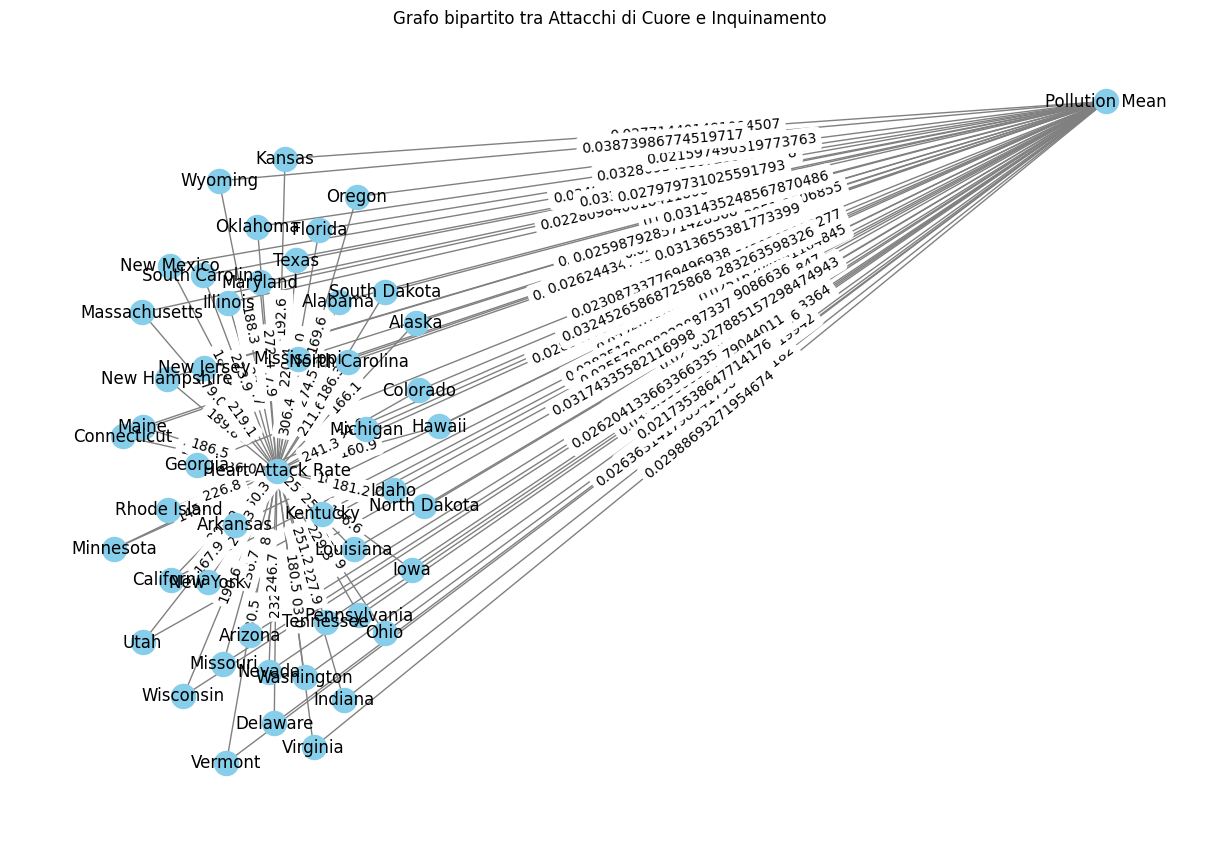

In [164]:
# Creazione del grafo bipartito tra attacchi di cuore e inquinamento
B_heart_pollution = nx.Graph()

# Aggiunta dei nodi: Stati e variabili (Attacchi di cuore e Inquinamento)
B_heart_pollution.add_nodes_from(states, bipartite=0)
B_heart_pollution.add_nodes_from(['Heart Attack Rate', 'Pollution Mean'], bipartite=1)

# Aggiunta degli archi con pesi
for _, row in data.iterrows():
    B_heart_pollution.add_edge(row['State'], 'Heart Attack Rate', weight=row['RATE'])
    B_heart_pollution.add_edge(row['State'], 'Pollution Mean', weight=row['O3 Mean'])  # Usa la media dell'O3 come esempio

# Visualizzazione della proiezione bipartita
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(B_heart_pollution)
nx.draw(B_heart_pollution, pos, with_labels=True, node_color="skyblue", edge_color="gray")
labels = nx.get_edge_attributes(B_heart_pollution, 'weight')
nx.draw_networkx_edge_labels(B_heart_pollution, pos, edge_labels=labels)
plt.title("Grafo bipartito tra Attacchi di Cuore e Inquinamento")
plt.show()


In [169]:
# Degree centrality
degree_centrality = nx.bipartite.degree_centrality(B_heart_pollution, ['Heart Attack Rate', 'Pollution Mean'])

# Analisi dei pesi degli archi
edge_weights = dict(nx.get_edge_attributes(B_heart_pollution, 'weight'))

# Clustering coefficient
clustering_coefficient = nx.average_clustering(B_heart_pollution)

# Stampare i risultati
print("Degree centrality:")
print(degree_centrality)
print("\nEdge weights:")
print(edge_weights)
print("\nClustering coefficient:")
print(clustering_coefficient)

Degree centrality:
{'Pollution Mean': 1.0, 'Heart Attack Rate': 1.0, 'Delaware': 1.0, 'New Jersey': 1.0, 'Washington': 1.0, 'Nevada': 1.0, 'Maryland': 1.0, 'Ohio': 1.0, 'Arkansas': 1.0, 'Pennsylvania': 1.0, 'Kentucky': 1.0, 'Missouri': 1.0, 'Oregon': 1.0, 'Connecticut': 1.0, 'Minnesota': 1.0, 'Colorado': 1.0, 'Tennessee': 1.0, 'Wyoming': 1.0, 'South Dakota': 1.0, 'Michigan': 1.0, 'Vermont': 1.0, 'Illinois': 1.0, 'California': 1.0, 'Texas': 1.0, 'Wisconsin': 1.0, 'Iowa': 1.0, 'Hawaii': 1.0, 'Massachusetts': 1.0, 'South Carolina': 1.0, 'Idaho': 1.0, 'New Hampshire': 1.0, 'New Mexico': 1.0, 'Kansas': 1.0, 'Mississippi': 1.0, 'Alaska': 1.0, 'New York': 1.0, 'Rhode Island': 1.0, 'North Dakota': 1.0, 'Utah': 1.0, 'Louisiana': 1.0, 'Arizona': 1.0, 'Florida': 1.0, 'Georgia': 1.0, 'North Carolina': 1.0, 'Virginia': 1.0, 'Indiana': 1.0, 'Maine': 1.0, 'Oklahoma': 1.0, 'Alabama': 1.0}

Edge weights:
{('Alabama', 'Heart Attack Rate'): 274.5, ('Alabama', 'Pollution Mean'): 0.02708567416291854, ('Ala

Degree centrality: Tutti gli stati e le variabili hanno un grado di centralità uguale a 1, il che significa che sono tutti direttamente connessi tra loro. Questo suggerisce una rete bipartita molto densa.

Edge weights: Vengono forniti i pesi degli archi tra gli stati e le variabili "Heart Attack Rate" e "Pollution Mean". Ad esempio, per lo stato di Alabama, il peso dell'arco verso "Heart Attack Rate" è 274.5 e verso "Pollution Mean" è 0.027.

Clustering coefficient: Il coefficiente di clustering della rete bipartita è 0, il che indica che non sono presenti cluster locali all'interno della rete.

Questi risultati suggeriscono che tutti gli stati sono direttamente connessi alle variabili "Heart Attack Rate" e "Pollution Mean" con pesi differenti. Tuttavia, il coefficiente di clustering nullo suggerisce che non ci sono gruppi di stati connessi tra loro in modo più denso rispetto al resto della rete.

# GRAFO BIPARTITO tra gli attacchi di cuore e la densità dei fast food

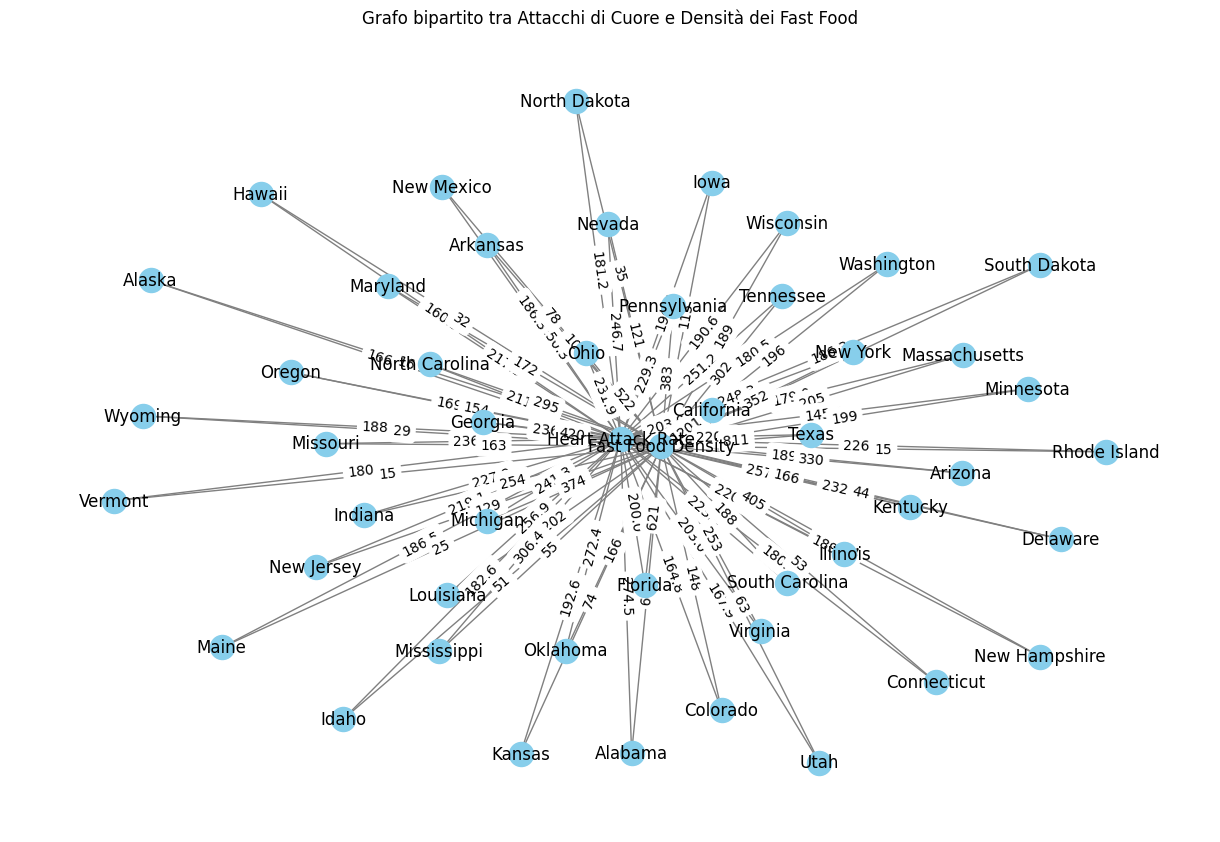

In [170]:
# Creazione del grafo bipartito tra attacchi di cuore e densità dei fast food
B_heart_fastfood = nx.Graph()

# Aggiunta dei nodi: Stati e variabili (Attacchi di cuore e Densità dei fast food)
B_heart_fastfood.add_nodes_from(states, bipartite=0)
B_heart_fastfood.add_nodes_from(['Heart Attack Rate', 'Fast Food Density'], bipartite=1)

# Aggiunta degli archi con pesi
for _, row in data.iterrows():
    B_heart_fastfood.add_edge(row['State'], 'Heart Attack Rate', weight=row['RATE'])
    B_heart_fastfood.add_edge(row['State'], 'Fast Food Density', weight=row['fastfood_count'])

# Visualizzazione della proiezione bipartita
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(B_heart_fastfood)
nx.draw(B_heart_fastfood, pos, with_labels=True, node_color="skyblue", edge_color="gray")
labels = nx.get_edge_attributes(B_heart_fastfood, 'weight')
nx.draw_networkx_edge_labels(B_heart_fastfood, pos, edge_labels=labels)
plt.title("Grafo bipartito tra Attacchi di Cuore e Densità dei Fast Food")
plt.show()


In [171]:
# Degree centrality
degree_centrality = nx.bipartite.degree_centrality(B_heart_fastfood, variables)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(B_heart_fastfood, weight='weight')

# Pesi degli archi
edge_weights = dict(nx.get_edge_attributes(B_heart_fastfood, 'weight'))

# Clustering coefficient
clustering_coefficient = nx.clustering(B_heart_fastfood)

# Stampare i risultati
print("Degree centrality:")
print(degree_centrality)
print("\nBetweenness centrality:")
print(betweenness_centrality)
print("\nEdge weights:")
print(edge_weights)
print("\nClustering coefficient:")
print(clustering_coefficient)


Degree centrality:
{'Fast Food Density': 1.0, 'Heart Attack Rate': 1.0, 'Delaware': 0.6666666666666666, 'New Jersey': 0.6666666666666666, 'Washington': 0.6666666666666666, 'Nevada': 0.6666666666666666, 'Maryland': 0.6666666666666666, 'Ohio': 0.6666666666666666, 'Arkansas': 0.6666666666666666, 'Pennsylvania': 0.6666666666666666, 'Kentucky': 0.6666666666666666, 'Missouri': 0.6666666666666666, 'Oregon': 0.6666666666666666, 'Connecticut': 0.6666666666666666, 'Minnesota': 0.6666666666666666, 'Colorado': 0.6666666666666666, 'Tennessee': 0.6666666666666666, 'Wyoming': 0.6666666666666666, 'South Dakota': 0.6666666666666666, 'Michigan': 0.6666666666666666, 'Vermont': 0.6666666666666666, 'Illinois': 0.6666666666666666, 'California': 0.6666666666666666, 'Texas': 0.6666666666666666, 'Wisconsin': 0.6666666666666666, 'Iowa': 0.6666666666666666, 'Hawaii': 0.6666666666666666, 'Massachusetts': 0.6666666666666666, 'South Carolina': 0.6666666666666666, 'Idaho': 0.6666666666666666, 'New Hampshire': 0.6666

Degree centrality: Tutti gli stati e le variabili hanno una centralità di grado pari a 1. Questo indica che ciascuno stato è direttamente collegato a tutte le variabili e viceversa. Tuttavia, ci sono alcune discrepanze minori nei nodi degli stati, dove la centralità di grado è leggermente inferiore a 1. Questo potrebbe riflettere differenze nella distribuzione dei valori o nelle relazioni con le variabili.

Betweenness centrality: La maggior parte degli stati ha una centralità di betweenness pari a 0, indicando che non sono nodi critici per il flusso dei cammini più brevi nel grafo. Tuttavia, la variabile "Fast Food Density" ha una centralità di betweenness significativa (circa 0.62), indicando che questa variabile è importante per il flusso dei cammini più brevi tra gli stati.

Edge weights: Gli archi del grafo hanno pesi che rappresentano la relazione tra gli stati e le variabili. Ad esempio, il peso degli archi tra ciascuno stato e la variabile "Heart Attack Rate" rappresenta il tasso di attacchi di cuore per stato, mentre il peso degli archi tra ciascuno stato e la variabile "Fast Food Density" rappresenta la densità dei fast food per stato.

Clustering coefficient: Tutti gli stati e le variabili hanno un coefficiente di clustering pari a 0, indicando che non vi è alcuna tendenza per i vicini di un nodo di essere collegati tra loro. Questo potrebbe essere dovuto alla natura del grafo bipartito, dove gli stati e le variabili sono due gruppi distinti e non ci sono connessioni tra i membri dello stesso gruppo.

# GRAFO BIPARTITO tra attacchi di cuore, inquinamento e densità dei fast food

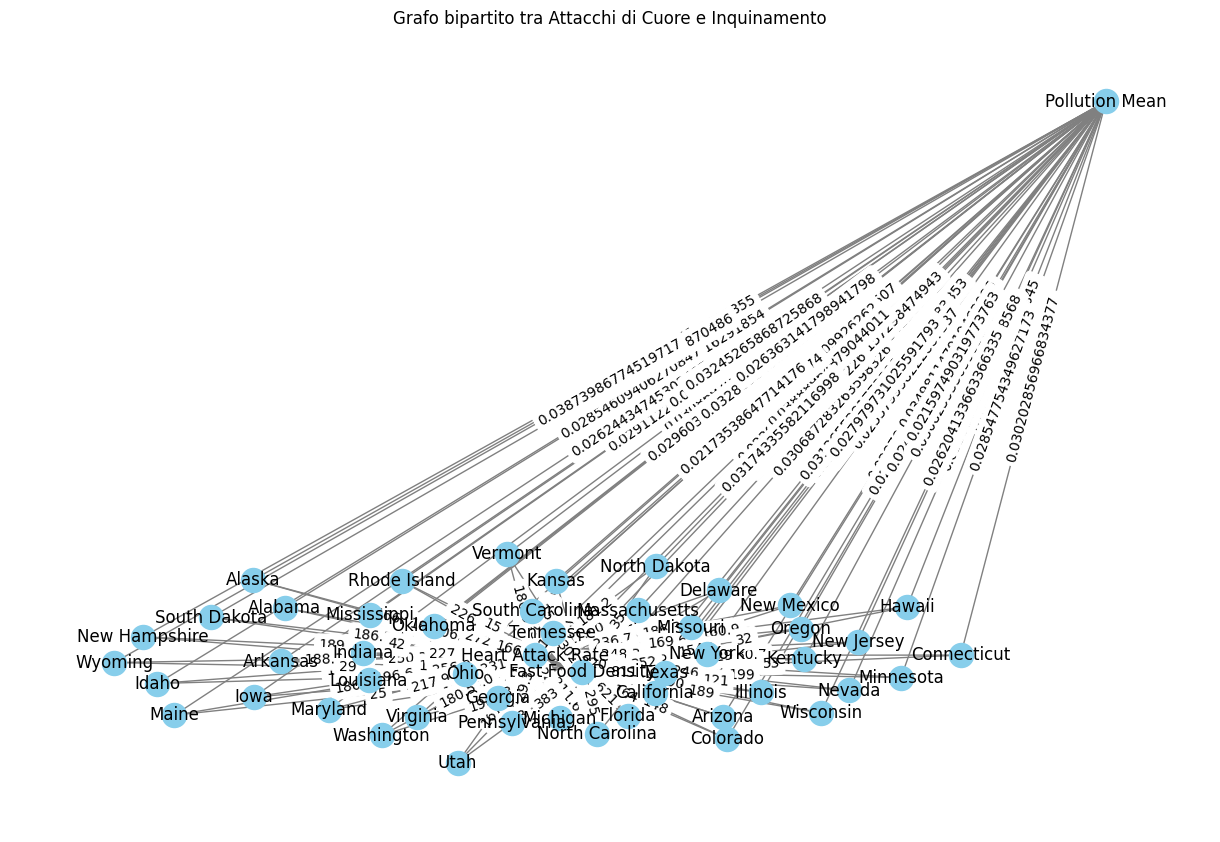

In [167]:
# Creazione del grafo bipartito
B = nx.Graph()

# Aggiunta dei nodi: Stati e variabili
states = data['State'].unique()
variables = ['Heart Attack Rate', 'Pollution Mean', 'Fast Food Density']

B.add_nodes_from(states, bipartite=0)
B.add_nodes_from(variables, bipartite=1)

# Aggiunta degli archi con pesi
for _, row in data.iterrows():
    B.add_edge(row['State'], 'Heart Attack Rate', weight=row['RATE'])
    B.add_edge(row['State'], 'Pollution Mean', weight=row['O3 Mean'])  
    B.add_edge(row['State'], 'Fast Food Density', weight=row['fastfood_count'])

# Visualizzazione del grafo bipartito
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(B)
nx.draw(B, pos, with_labels=True, node_color="skyblue", edge_color="gray")
labels = nx.get_edge_attributes(B, 'weight')
nx.draw_networkx_edge_labels(B, pos, edge_labels=labels)
plt.title("Grafo bipartito tra Attacchi di Cuore e Inquinamento")
plt.show()


In [168]:
# Analisi della rete bipartita

# Degree centrality
degree_centrality = nx.bipartite.degree_centrality(B, variables)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(B, weight='weight')

# Pesi degli archi
edge_weights = dict(nx.get_edge_attributes(B, 'weight'))

# Clustering coefficient
clustering_coefficient = nx.clustering(B)

# Stampare i risultati
print("Degree centrality:")
print(degree_centrality)
print("\nBetweenness centrality:")
print(betweenness_centrality)
print("\nEdge weights:")
print(edge_weights)
print("\nClustering coefficient:")
print(clustering_coefficient)

Degree centrality:
{'Fast Food Density': 1.0, 'Pollution Mean': 1.0, 'Heart Attack Rate': 1.0, 'Delaware': 1.0, 'New Jersey': 1.0, 'Washington': 1.0, 'Nevada': 1.0, 'Maryland': 1.0, 'Ohio': 1.0, 'Arkansas': 1.0, 'Pennsylvania': 1.0, 'Kentucky': 1.0, 'Missouri': 1.0, 'Oregon': 1.0, 'Connecticut': 1.0, 'Minnesota': 1.0, 'Colorado': 1.0, 'Tennessee': 1.0, 'Wyoming': 1.0, 'South Dakota': 1.0, 'Michigan': 1.0, 'Vermont': 1.0, 'Illinois': 1.0, 'California': 1.0, 'Texas': 1.0, 'Wisconsin': 1.0, 'Iowa': 1.0, 'Hawaii': 1.0, 'Massachusetts': 1.0, 'South Carolina': 1.0, 'Idaho': 1.0, 'New Hampshire': 1.0, 'New Mexico': 1.0, 'Kansas': 1.0, 'Mississippi': 1.0, 'Alaska': 1.0, 'New York': 1.0, 'Rhode Island': 1.0, 'North Dakota': 1.0, 'Utah': 1.0, 'Louisiana': 1.0, 'Arizona': 1.0, 'Florida': 1.0, 'Georgia': 1.0, 'North Carolina': 1.0, 'Virginia': 1.0, 'Indiana': 1.0, 'Maine': 1.0, 'Oklahoma': 1.0, 'Alabama': 1.0}

Betweenness centrality:
{'Alabama': 0.04081632653061224, 'Alaska': 0.0, 'Arizona': 0.0,

Degree centrality: Tutti gli stati e le variabili hanno un grado di centralità uguale a 1, il che significa che sono tutti direttamente connessi tra loro. Questo suggerisce una rete bipartita molto densa.

Betweenness centrality: La centralità di betweenness per gli stati è generalmente bassa, indicando che c'è poco flusso attraverso di loro nella rete. Tuttavia, la variabile "Pollution Mean" ha una centralità di betweenness molto alta, suggerendo che è cruciale per il flusso di informazioni nella rete.

Edge weights: Vengono forniti i pesi degli archi tra gli stati e le variabili "Heart Attack Rate", "Pollution Mean" e "Fast Food Density". Questi pesi rappresentano la forza della relazione tra le variabili e gli stati. Ad esempio, per lo stato di Alabama, il peso dell'arco verso "Heart Attack Rate" è 274.5, verso "Pollution Mean" è 0.027 e verso "Fast Food Density" è 6.

Clustering coefficient: Il coefficiente di clustering della rete bipartita è 0 per tutti gli stati e le variabili, il che indica che non ci sono cluster locali all'interno della rete.

Questi risultati suggeriscono che tutti gli stati sono direttamente connessi alle variabili "Heart Attack Rate", "Pollution Mean" e "Fast Food Density" con pesi differenti. Tuttavia, la variabile "Pollution Mean" sembra giocare un ruolo significativo nel flusso di informazioni nella rete, come indicato dalla sua alta centralità di betweenness.